In [ ]:
# %% [markdown]
# ## 1. Imports and Configurations

# %%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from collections import deque, namedtuple
import random
from tqdm import tqdm  # For progress bars
import logging  # For logging
from sklearn.preprocessing import StandardScaler  # For input normalization
from hmmlearn import hmm  # Ensure regime_detection.py has been run

# Configure logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Check if handlers are already attached to prevent duplication
if not logger.handlers:
    handler = logging.FileHandler("training_ddpg.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

# Disable propagation to prevent duplicate logs
logger.propagate = False

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %% [markdown]
# ## 2. Adaptive Transformer Network Definitions

# %%
class RegimeConditionedLayerNorm(nn.Module):
    """
    Layer Normalization conditioned on the market regime.
    """
    def __init__(self, normalized_shape, num_regimes=2):
        super(RegimeConditionedLayerNorm, self).__init__()
        self.num_regimes = num_regimes
        self.layer_norms = nn.ModuleList([nn.LayerNorm(normalized_shape) for _ in range(num_regimes)])
    
    def forward(self, x, regime):
        """
        Forward pass for regime-conditioned layer normalization.
       
        Parameters:
        - x (Tensor): Input tensor.
        - regime (Tensor): One-hot encoded regime tensor.
       
        Returns:
        - Tensor: Normalized tensor.
        """
        # regime is one-hot encoded
        # Determine which layer norm to apply based on regime
        regime_index = torch.argmax(regime, dim=-1)  # shape: (batch_size,)
        normalized = torch.zeros_like(x)
        for i in range(self.num_regimes):
            mask = (regime_index == i).unsqueeze(-1).unsqueeze(-1)
            if mask.sum() > 0:
                normalized += self.layer_norms[i](x) * mask.float()
        return normalized

class RegimeWeightedAttention(nn.Module):
    """
    Attention mechanism weighted by regime probabilities.
    """
    def __init__(self, d_model, nhead, dropout=0.1):
        super(RegimeWeightedAttention, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.regime_weight = nn.Linear(2, 1)  # Assuming two regimes: Calm and Volatile
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, x, regime, attn_mask=None):
        """
        Forward pass with regime-weighted attention.
        
        Parameters:
        - x (Tensor): Input tensor (batch_size, seq_length, d_model).
        - regime (Tensor): One-hot encoded regime tensor (batch_size, 2).
        - attn_mask (Tensor): Attention mask.
        
        Returns:
        - Tensor: Output tensor after attention and normalization.
        """
        # Calculate regime weights
        regime_weights = self.regime_weight(regime)  # shape: (batch_size, 1)
        regime_weights = regime_weights.squeeze(-1).unsqueeze(1).unsqueeze(2)  # shape: (batch_size, 1, 1)
        
        # Apply self-attention
        attn_output, attn_weights = self.self_attn(x, x, x, attn_mask=attn_mask)
        
        # Weight the attention output based on regime
        attn_output = attn_output * regime_weights
        
        # Apply dropout and residual connection
        x = self.dropout(attn_output) + x
        
        # Apply layer normalization
        x = self.layer_norm(x)
        
        return x

class AdaptiveTransformerEncoderLayer(nn.Module):
    """
    Transformer Encoder Layer with regime-dependent modifications.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu'):
        super(AdaptiveTransformerEncoderLayer, self).__init__()
        self.self_attn = RegimeWeightedAttention(d_model, nhead, dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        self.regime_layer_norm = RegimeConditionedLayerNorm(d_model, num_regimes=2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        if activation == "relu":
            self.activation = F.relu
        elif activation == "gelu":
            self.activation = F.gelu
        else:
            raise RuntimeError("activation should be relu or gelu, not {}".format(activation))
    
    def forward(self, src, regime, attn_mask=None):
        """
        Pass the input through the encoder layer.
        
        Parameters:
        - src (Tensor): Input tensor (batch_size, seq_length, d_model).
        - regime (Tensor): One-hot encoded regime tensor (batch_size, 2).
        - attn_mask (Tensor): Attention mask.
        
        Returns:
        - Tensor: Output tensor.
        """
        # Self-Attention with regime weighting
        src2 = self.self_attn(src, regime, attn_mask=attn_mask)
        src = src + self.dropout1(src2)
        src = self.regime_layer_norm(src, regime)
        
        # Feedforward network
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.regime_layer_norm(src, regime)
        return src

class AdaptiveTransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(AdaptiveTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
    
    def forward(self, src, regime, attn_mask=None):
        """
        Pass the input through each layer in turn.
        
        Parameters:
        - src (Tensor): Input tensor (batch_size, seq_length, d_model).
        - regime (Tensor): One-hot encoded regime tensor (batch_size, 2).
        - attn_mask (Tensor): Attention mask.
        
        Returns:
        - Tensor: Output tensor after all layers.
        """
        for layer in self.layers:
            src = layer(src, regime, attn_mask=attn_mask)
        return src

class AdaptiveTransformerActor(nn.Module):
    def __init__(self, config):
        super(AdaptiveTransformerActor, self).__init__()
        self.num_features = config['num_features']
        self.action_dim = config['action_dim']
        self.d_model = config['d_model']
        self.window_length = config['window_length']
        self.num_assets_plus_cash = config['num_assets']
        self.seq_len = self.window_length  # Sequence length for transformer

        # Define layers
        self.input_linear = nn.Linear(self.num_assets_plus_cash * self.num_features, self.d_model)
        
        # Positional Encoding
        self.positional_encoding = self.generate_positional_encoding(self.seq_len, self.d_model)
        
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=self.d_model, 
            nhead=config['nhead'], 
            dim_feedforward=config['dim_feedforward'], 
            dropout=config['dropout']
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=config['num_encoder_layers'])
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.seq_len * self.d_model, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, self.action_dim)
        
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(config['dropout'])
        
    def generate_positional_encoding(self, seq_length, d_model):
        """
        Generates sinusoidal positional encoding.
        """
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, seq_length, d_model)
        return pe  # Non-trainable positional encoding
    
    def forward(self, x, regime):
        """
        Forward pass of the actor network.
        
        Parameters:
        - x (Tensor): Input tensor (batch_size, num_assets +1, window_length, num_features).
        - regime (Tensor): One-hot encoded regime tensor (batch_size, 2).
        
        Returns:
        - Tensor: Portfolio weights (batch_size, action_dim).
        """
        batch_size = x.size(0)
        
        # Reshape to (batch_size, window_length, num_assets +1 * num_features)
        x = x.permute(0, 2, 1, 3).contiguous()  # (batch_size, window_length, num_assets +1, num_features)
        x = x.view(batch_size, self.seq_len, -1)  # (batch_size, window_length, num_assets +1 * num_features)
        # print(f"Actor Input Shape after reshaping: {x.shape}")  # Debugging
        
        # Input embedding
        x = self.input_linear(x)  # (batch_size, window_length, d_model)
        # print(f"Actor Input Shape after input_linear: {x.shape}")  # Debugging
        
        # Add positional encoding
        x = x + self.positional_encoding[:, :self.seq_len, :]  # Shape: (batch_size, window_length, d_model)
        # print(f"Actor Input Shape after positional encoding: {x.shape}")  # Debugging
        
        # Transformer Encoder
        x = self.transformer_encoder(x)  # (batch_size, window_length, d_model)
        # print(f"Actor Input Shape after transformer_encoder: {x.shape}")  # Debugging
        
        # Flatten
        x = x.view(batch_size, -1)  # (batch_size, window_length * d_model)
        # print(f"Actor Input Shape after flattening for FC layers: {x.shape}")  # Debugging
        
        # Fully connected layers
        x = self.dropout_layer(self.relu(self.fc1(x)))  # (batch_size, 512)
        x = self.dropout_layer(self.relu(self.fc2(x)))  # (batch_size, 256)
        x = self.dropout_layer(self.relu(self.fc3(x)))  # (batch_size, 128)
        x = self.fc4(x)  # (batch_size, action_dim)
        
        # Softmax to get portfolio weights
        weights = nn.functional.softmax(x, dim=-1)
        return weights


class AdaptiveTransformerCritic(nn.Module):
    def __init__(self, config):
        super(AdaptiveTransformerCritic, self).__init__()
        self.num_features = config['num_features']
        self.action_dim = config['action_dim']
        self.d_model = config['d_model']
        self.window_length = config['window_length']
        self.num_assets_plus_cash = config['num_assets']
        self.seq_len = self.window_length  # Sequence length for transformer

        # Define layers
        self.state_linear = nn.Linear(self.num_assets_plus_cash * self.num_features, self.d_model)
        self.action_embedding = nn.Linear(self.action_dim, self.d_model)
        self.regime_embedding = nn.Linear(2, self.d_model)  # Assuming regimes are one-hot encoded with 2 dimensions

        # Positional Encoding
        self.positional_encoding = self.generate_positional_encoding(self.seq_len, self.d_model)
        
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=self.d_model, 
            nhead=config['nhead'], 
            dim_feedforward=config['dim_feedforward'], 
            dropout=config['dropout']
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=config['num_encoder_layers'])

        # Fully connected layers
        self.fc1 = nn.Linear(self.seq_len * self.d_model, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)  # Output a single Q-value

        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(config['dropout'])

    def generate_positional_encoding(self, seq_length, d_model):
        """
        Generates sinusoidal positional encoding.
        """
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, seq_length, d_model)
        return pe  # Non-trainable positional encoding

    def forward(self, state, action, regimes):
        """
        Forward pass of the critic network.

        Parameters:
        - state (Tensor): Input tensor (batch_size, num_assets +1, window_length, num_features).
        - action (Tensor): Action tensor (batch_size, action_dim).
        - regimes (Tensor): Regime tensor (batch_size, 2).

        Returns:
        - Tensor: Q-value (batch_size, 1).
        """
        batch_size = state.size(0)

        # Reshape state to (batch_size, window_length, num_assets +1 * num_features)
        state = state.permute(0, 2, 1, 3).contiguous()  # (batch_size, window_length, num_assets +1, num_features)
        state = state.view(batch_size, self.seq_len, -1)  # (batch_size, window_length, num_assets +1 * num_features)
        # print(f"Critic State Shape after reshaping: {state.shape}")  # Debugging

        # Embed state
        state_embedded = self.state_linear(state)  # (batch_size, window_length, d_model)
        # print(f"Critic State Shape after state_linear: {state_embedded.shape}")  # Debugging

        # Embed action
        action_embedded = self.action_embedding(action)  # (batch_size, d_model)
        action_embedded = action_embedded.unsqueeze(1).repeat(1, self.seq_len, 1)  # (batch_size, window_length, d_model)
        # print(f"Critic Action Shape after embedding: {action_embedded.shape}")  # Debugging

        # Embed regimes
        regime_embedded = self.regime_embedding(regimes)  # (batch_size, d_model)
        regime_embedded = regime_embedded.unsqueeze(1).repeat(1, self.seq_len, 1)  # (batch_size, window_length, d_model)
        # print(f"Critic Regime Shape after embedding: {regime_embedded.shape}")  # Debugging

        # Combine state, action, and regime embeddings
        combined = state_embedded + action_embedded + regime_embedded  # (batch_size, window_length, d_model)
        # print(f"Critic Combined Shape after addition: {combined.shape}")  # Debugging

        # Add positional encoding
        combined = combined + self.positional_encoding[:, :self.seq_len, :]  # (batch_size, window_length, d_model)
        # print(f"Critic Combined Shape after positional encoding: {combined.shape}")  # Debugging

        # Transformer Encoder
        combined = self.transformer_encoder(combined)  # (batch_size, window_length, d_model)
        # print(f"Critic Combined Shape after transformer_encoder: {combined.shape}")  # Debugging

        # Flatten
        combined = combined.view(batch_size, -1)  # (batch_size, window_length * d_model)
        # print(f"Critic Combined Shape after flattening for FC layers: {combined.shape}")  # Debugging

        # Fully connected layers
        combined = self.dropout_layer(self.relu(self.fc1(combined)))  # (batch_size, 512)
        combined = self.dropout_layer(self.relu(self.fc2(combined)))  # (batch_size, 256)
        combined = self.dropout_layer(self.relu(self.fc3(combined)))  # (batch_size, 128)
        q_value = self.fc4(combined)  # (batch_size, 1)
        # print(f"Critic Q-Value Shape: {q_value.shape}")  # Debugging

        return q_value

# %% [markdown]
# ## 3. DDPG Agent Definitions

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.pos = 0
        self.priorities = []
   
    def add(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities, default=1.0)
        if len(self.buffer) < self.capacity:
            self.buffer.append(Transition(state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.buffer[self.pos] = Transition(state, action, reward, next_state, done)
            self.priorities[self.pos] = max_priority
            self.pos = (self.pos + 1) % self.capacity
   
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            priorities = np.array(self.priorities)
        else:
            priorities = np.array(self.priorities[:len(self.buffer)])
       
        if priorities.sum() == 0:
            probabilities = np.ones_like(priorities) / len(priorities)
        else:
            probabilities = priorities ** self.alpha
            probabilities /= probabilities.sum()
       
        if len(probabilities) < batch_size:
            raise ValueError(f"Not enough samples to draw from. Buffer size: {len(probabilities)}, batch_size: {batch_size}")
       
        try:
            indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        except ValueError as e:
            print(f"Buffer length: {len(self.buffer)}, Probabilities sum: {probabilities.sum()}")
            raise e
        samples = [self.buffer[idx] for idx in indices]
       
        total = len(self.buffer)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
       
        batch = Transition(*zip(*samples))
        states = np.array(batch.state)
        actions = np.array(batch.action)
        rewards = np.array(batch.reward)
        next_states = np.array(batch.next_state)
        dones = np.array(batch.done)
       
        return states, actions, rewards, next_states, dones, indices, weights
   
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority
   
    def __len__(self):
        return len(self.buffer)

class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()
   
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
   
    def sample(self, decay=1.0):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state = self.state + dx * decay
        return self.state

class DDPGAgentAdaptive:
    def __init__(self, config):
        self.state_dim = config['state_dim']
        self.action_dim = config['action_dim']
        self.num_regimes = config['num_regimes']
        self.num_assets = config['num_assets']
        self.window_length = config['window_length']
        self.num_features = config['num_features']
        
        # Initialize Actor and Critic networks
        self.actor = AdaptiveTransformerActor(config).to(config['device'])
        self.actor_target = AdaptiveTransformerActor(config).to(config['device'])
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=config['actor_lr'])
        
        self.critic = AdaptiveTransformerCritic(config).to(config['device'])
        self.critic_target = AdaptiveTransformerCritic(config).to(config['device'])
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=config['critic_lr'])
        
        # Replay Buffer
        self.replay_buffer = PrioritizedReplayBuffer(config['buffer_size'], alpha=config['alpha'])
        self.batch_size = config['batch_size']
        self.gamma = config['gamma']
        self.tau = config['tau']
        
        # Noise for exploration
        self.noise = OUNoise(self.action_dim, theta=0.15, sigma=0.2)
        
        # Scheduler (optional)
        self.actor_scheduler = optim.lr_scheduler.StepLR(
            self.actor_optimizer, step_size=10000, gamma=0.1
        )
        self.critic_scheduler = optim.lr_scheduler.StepLR(
            self.critic_optimizer, step_size=10000, gamma=0.1
        )
        
        # Device
        self.device = config['device']
        
    def select_action(self, state, regime, add_noise=True):
        self.actor.eval()
        
        # Convert state to PyTorch tensor
        state_tensor = torch.FloatTensor(state).to(self.device)  # Shape: (num_assets +1, window_length, num_features)
        
        # Add batch dimension if not present
        if len(state_tensor.shape) == 3:
            state_tensor = state_tensor.unsqueeze(0)  # Shape: (1, num_assets +1, window_length, num_features)
        
        # Convert regime to PyTorch tensor
        regime_tensor = torch.FloatTensor(regime).to(self.device)  # Shape: (batch_size, 2)
        
        with torch.no_grad():
            action = self.actor(state_tensor, regime_tensor).cpu().data.numpy().flatten()  # Shape: (action_dim,)
            # print(f"Action shape: {action.shape}")  # Debugging
        
        self.actor.train()
        
        if add_noise:
            noise = self.noise.sample(decay=1.0)  # Shape: (action_dim,)
            # print(f"Noise shape: {noise.shape}")  # Debugging
            if noise.shape != action.shape:
                raise ValueError(f"Noise shape {noise.shape} does not match action shape {action.shape}")
            action = action * 0.9 + noise * 0.1  # Action smoothing
        
        return np.clip(action, 0, 1)
    
    def train_step(self, beta=0.4):
        if len(self.replay_buffer) < self.batch_size:
            return None, None, None
        
        # Sample a batch
        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(self.batch_size, beta=beta)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        weights = torch.FloatTensor(weights).unsqueeze(1).to(self.device)
        
        # Reshape states and next_states to (batch_size, num_assets +1, window_length, num_features)
        states = states.view(self.batch_size, self.num_assets, self.window_length, self.num_features)
        next_states = next_states.view(self.batch_size, self.num_assets, self.window_length, self.num_features)
        
        # print(f"Train Step - States Shape: {states.shape}")  # Debugging
        # print(f"Train Step - Next States Shape: {next_states.shape}")  # Debugging
        
        # Assume regimes are part of the state features
        # Extract regime information from the state
        # For simplicity, let's assume the last two features are one-hot encoded regimes
        # Adjust indexing based on actual data structure
        regimes = states[:, -1, -1, -2:].reshape(-1, 2)  # (batch_size, 2)
        # print(f"Train Step - Regimes Shape: {regimes.shape}")  # Debugging
        
        # Critic Update
        with torch.no_grad():
            next_actions = self.actor_target(next_states, regimes)
            target_q = self.critic_target(next_states, next_actions, regimes)
            y = rewards + self.gamma * target_q * (1 - dones)
        
        current_q = self.critic(states, actions, regimes)
        td_errors = current_q - y
        critic_loss = (td_errors.pow(2) * weights).mean()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()
        
        # Update priorities
        new_priorities = td_errors.abs().detach().cpu().numpy() + 1e-6
        self.replay_buffer.update_priorities(indices, new_priorities.flatten())
        
        # Actor Update
        actor_loss = -self.critic(states, self.actor(states, regimes), regimes).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        
        # Soft update target networks
        self.soft_update(self.actor, self.actor_target)
        self.soft_update(self.critic, self.critic_target)
        
        # Soft update schedulers
        self.actor_scheduler.step()
        self.critic_scheduler.step()
        
        return actor_loss.item(), critic_loss.item(), current_q.mean().item()

    def soft_update(self, source, target):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * source_param.data + (1.0 - self.tau) * target_param.data)
    
    def save(self, path):
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'actor_target_state_dict': self.actor_target.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'critic_target_state_dict': self.critic_target.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.actor_target.load_state_dict(checkpoint['actor_target_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.critic_target.load_state_dict(checkpoint['critic_target_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])

# %% [markdown]
# ## 4. Custom Portfolio Environment

# %%
class PortfolioEnv(gym.Env):
    """
    Custom Gym environment for portfolio management.
    Observations are based on preprocessed CSV data.
    Actions are portfolio weights.
    Incorporates market regime (Calm/Volatile) into observations.
    """
    def __init__(self, config):
        super(PortfolioEnv, self).__init__()
       
        self.data = config['data']
        self.symbols = config['symbols']
        self.initial_balance = config['initial_balance']
        self.window_length = config['window_length']
        self.train = config['train']
        self.volatility_window = config['volatility_window']
        self.risk_free_rate = config['risk_free_rate']
       
        # Define macroeconomic factors explicitly
        self.macro_columns = ['GDP', 'CPI', 'Unemployment_Rate']
        self.regime_column = 'Regime'
       
        # Split data into train and test based on date ranges
        if self.train:
            if not config['train_start_date'] or not config['train_end_date']:
                raise ValueError("Train start and end dates must be provided for training.")
            self.current_dates = sorted(self.data[
                (self.data['Date'] >= config['train_start_date']) & 
                (self.data['Date'] <= config['train_end_date'])
            ]['Date'].unique())
        else:
            if not config['test_start_date'] or not config['test_end_date']:
                raise ValueError("Test start and end dates must be provided for testing.")
            self.current_dates = sorted(self.data[
                (self.data['Date'] >= config['test_start_date']) & 
                (self.data['Date'] <= config['test_end_date'])
            ]['Date'].unique())
       
        self.current_step = self.window_length
        self.balance = self.initial_balance  # Fixed here
        self.portfolio = np.zeros(len(self.symbols) + 1)  # +1 for cash
        self.portfolio[0] = 1.0  # start with all in cash

        # Initialize historical maximum balance for drawdown calculation
        self.historical_max_balance = self.initial_balance
       
        # Initialize recent returns deque for volatility calculation
        self.recent_returns = deque(maxlen=self.volatility_window)
       
        # Define action and observation space
        # Action: portfolio weights for each asset + cash (sum to 1)
        self.action_space = spaces.Box(low=0, high=1, shape=(len(self.symbols) + 1,), dtype=np.float32)
       
        # Observation: window_length x num_features
        # Including regime as an additional feature
        # Features: ['Adj Close', 'Volume', 'Return', 'MA_10', 'MA_50', 'RSI', 'MACD', 'Realized_Volatility', 'Regime']
        self.num_features = len(self.data.columns) - 3  # excluding Date, Symbol, Regime
       
        self.observation_space = spaces.Box(
            low=-np.inf, 
            high=np.inf,
            shape=(len(self.symbols) + 1, self.window_length, self.num_features),
            dtype=np.float32
        )
       
        # Prepare data per symbol
        self.symbol_data = {}
        for symbol in self.symbols:
            self.symbol_data[symbol] = self.data[self.data['Symbol'] == symbol].sort_values('Date').reset_index(drop=True)
       
        # Create list of dates for environment
        self.dates = sorted(self.data['Date'].unique())
        self.num_steps = len(self.current_dates)

        # Initialize feature scaler
        if config['scaler'] is None:
            self.scaler = StandardScaler()
            # Fit scaler on all features in training data
            if self.train:
                feature_data = self.data.drop(['Date', 'Symbol', self.regime_column], axis=1).values  # Convert to NumPy array
                self.scaler.fit(feature_data)
        else:
            self.scaler = config['scaler']

        self.reset()

    def reset(self):
        # Reset the environment to initial state
        self.balance = self.initial_balance  # Fixed here
        self.portfolio = np.zeros(len(self.symbols) + 1)
        self.portfolio[0] = 1.0  # start with all in cash
        self.historical_max_balance = self.initial_balance
        self.portfolio_history = [self.initial_balance]
        self.recent_returns.clear()
        self.current_step = self.window_length
        self._last_observation = self._next_observation()
        return self._last_observation

    def _next_observation(self):
        """
        Get the next observation (window_length steps of data)
        Includes regime information.
        """
        if self.current_step >= len(self.current_dates):
            # If out of range, return the last valid observation
            return self._last_observation.copy()
    
        # Get current date
        current_date = self.current_dates[self.current_step]
        # Get window of data
        obs = []
        for symbol in self.symbols:
            symbol_df = self.symbol_data[symbol]
            # Get data up to current_step
            data_window = symbol_df[symbol_df['Date'] <= current_date].tail(self.window_length)
            if len(data_window) < self.window_length:
                # Pad with last available data
                padding = self.window_length - len(data_window)
                if len(data_window) == 0:
                    # If no data available, pad with zeros
                    pad_array = np.zeros((padding, len(symbol_df.columns) - 3))  # Exclude Date, Symbol, Regime
                else:
                    last_rows = data_window.iloc[-1].drop(['Date', 'Symbol', self.regime_column]).values
                    pad_array = np.tile(last_rows, (padding, 1))
                pad_df = pd.DataFrame(pad_array, columns=data_window.columns.drop(['Date', 'Symbol', self.regime_column]))
                data_window = pd.concat([pad_df, data_window], ignore_index=True)
            # Ensure data_window has exactly window_length rows
            data_window = data_window.tail(self.window_length)
            # Extract features (drop non-feature columns)
            features = data_window.drop(['Date', 'Symbol', self.regime_column], axis=1).values  # shape: (window_length, num_features)
            obs.append(features)
    
        # Add cash as a constant feature
        # Represent cash with a specific pattern, e.g., all ones
        cash_feature = np.ones((self.window_length, self.num_features))  # shape: (window_length, num_features)
        obs.append(cash_feature)
    
        # Convert to numpy array
        try:
            obs = np.array(obs)  # shape: (num_assets +1, window_length, num_features)
        except ValueError as e:
            # Debugging information
            print("Error converting obs to numpy array.")
            for idx, arr in enumerate(obs):
                print(f"Asset {idx} shape: {arr.shape}")
            raise e
    
        # Incorporate regime information
        # Get regime for current_date
        regime = self.data[self.data['Date'] == current_date][self.regime_column].unique()
        if len(regime) == 0:
            regime = 'Calm'  # Default to Calm if not found
        else:
            regime = regime[0]
        # Encode regime as one-hot
        regime_one_hot = np.array([1.0, 0.0]) if regime == 'Calm' else np.array([0.0, 1.0])
        # Note: Do NOT concatenate regime_encoded to features
    
        # Normalize the numerical features only
        features_normalized = self.scaler.transform(obs.reshape(-1, self.num_features)).reshape(obs.shape)  # (num_assets +1, window_length, num_features)
    
        # Update last_observation
        self._last_observation = features_normalized.astype(np.float32)
    
        return self._last_observation



    def _calculate_sharpe_ratio(self):
        """
        Calculate the Sharpe Ratio based on recent returns using a rolling window.
        Incorporates the risk-free rate.
        Assumes daily returns and risk-free rate is annualized.
        """
        returns = np.array(self.recent_returns)
        if len(returns) < self.volatility_window:
            return 0.0
        
        # Calculate daily risk-free rate
        daily_risk_free_rate = self.risk_free_rate / 252
        
        # Calculate excess returns
        excess_returns = returns - daily_risk_free_rate
        
        # Calculate Sharpe Ratio
        sharpe_ratio = np.mean(excess_returns) / (np.std(excess_returns) + 1e-8) * np.sqrt(252)  # Annualized
        
        return sharpe_ratio

    def _calculate_current_drawdown(self):
        """
        Calculate Current Drawdown from current balance and historical maximum.
        """
        drawdown = (self.historical_max_balance - self.balance) / self.historical_max_balance
        return drawdown

    def step(self, action, reward_coefficients=None):
        """
        Execute one time step within the environment.
       
        Parameters:
        - action (np.array): Portfolio weights including cash.
        - reward_coefficients (dict): Tunable coefficients for reward components.
       
        Returns:
        - next_observation (np.array): Next state.
        - reward (float): Calculated reward.
        - done (bool): Whether the episode is done.
        - info (dict): Additional information.
        """
        # Default reward coefficients if not provided
        if reward_coefficients is None:
            reward_coefficients = {
                'return_weight': 1.0,
                'sharpe_weight': 0.01,  # Adjusted weight
                'drawdown_penalty': 1.0  # Adjust as needed
            }
       
        # Clip and normalize action
        action = np.clip(action, 0, 1)
        action_sum = action.sum()
        if action_sum == 0:
            action_sum = 1e-8  # Prevent division by zero
        action /= action_sum
        # Update portfolio weights
        self.portfolio = action
        # Calculate portfolio return
        # Get current date and next date
        current_date = self.current_dates[self.current_step]
        next_step = self.current_step + 1
        if next_step >= len(self.current_dates):
            done = True
            next_date = current_date
        else:
            done = False
            next_date = self.current_dates[next_step]
        # Get returns
        returns = []
        for symbol in self.symbols:
            symbol_df = self.symbol_data[symbol]
            current_price = symbol_df[symbol_df['Date'] == current_date]['Adj Close'].values
            next_price = symbol_df[symbol_df['Date'] == next_date]['Adj Close'].values
            if len(current_price) == 0 or len(next_price) == 0:
                return_rate = 0
            else:
                return_rate = (next_price[0] - current_price[0]) / current_price[0]
            returns.append(return_rate)
        # Assume cash has a fixed return, e.g., 0
        returns = np.array([0] + returns)  # first is cash
        # Calculate portfolio return
        portfolio_return = np.dot(self.portfolio, returns)
        # Update balance
        self.balance *= (1 + portfolio_return)
       
        # Update historical maximum balance
        if self.balance > self.historical_max_balance:
            self.historical_max_balance = self.balance
       
        # Update portfolio value history for drawdown calculations
        self.portfolio_history.append(self.balance)
       
        # Update recent returns
        self.recent_returns.append(portfolio_return)
       
        # Calculate Sharpe Ratio using rolling window
        sharpe_ratio = self._calculate_sharpe_ratio()
       
        # Calculate Current Drawdown
        current_drawdown = self._calculate_current_drawdown()
       
        # Scale and normalize reward components
        scaled_portfolio_return = reward_coefficients['return_weight'] * portfolio_return
        scaled_sharpe_ratio = reward_coefficients['sharpe_weight'] * sharpe_ratio
        scaled_drawdown = reward_coefficients['drawdown_penalty'] * current_drawdown
       
        # Compute the final reward
        reward = (
            scaled_portfolio_return +
            scaled_sharpe_ratio -
            scaled_drawdown
        )
       
        # Clip rewards to prevent extreme values
        reward = np.clip(reward, -5, 5)
       
        # Log individual reward components
        logger.debug(f"Return Component: {scaled_portfolio_return:.4f}")
        logger.debug(f"Sharpe Component: {scaled_sharpe_ratio:.4f}")
        logger.debug(f"Drawdown Penalty: {scaled_drawdown:.4f}")
       
        # Update step
        self.current_step += 1
        # Get next observation
        next_observation = self._next_observation()
       
        # Log additional info
        info = {
            'scaled_portfolio_return': scaled_portfolio_return,
            'scaled_sharpe_ratio': scaled_sharpe_ratio,
            'scaled_drawdown': scaled_drawdown,
            'portfolio_value': self.balance,
            'sharpe_ratio': sharpe_ratio,
            'current_drawdown': current_drawdown,
            'portfolio_return': portfolio_return,  # Added to fix KeyError
            'portfolio_weights': self.portfolio.copy(),  # Added to log portfolio weights
            'current_regime': self.data[self.data['Date'] == current_date][self.regime_column].values[0] if len(self.data[self.data['Date'] == current_date][self.regime_column].values) > 0 else 'Calm'
        }
       
        return next_observation, reward, done, info

# %% [markdown]
# ## 5. Training and Testing Functions

# %%
def calculate_sharpe_ratio(rewards, risk_free_rate=0.02):
    """
    Calculate the Sharpe Ratio for the rewards.

    Parameters:
    - rewards (list or np.array): List of rewards (returns).
    - risk_free_rate (float): Risk-free rate.

    Returns:
    - float: Sharpe Ratio
    """
    returns = np.array(rewards)
    excess_returns = returns - risk_free_rate / 252  # Assuming daily returns
    sharpe_ratio = np.mean(excess_returns) / (np.std(excess_returns) + 1e-10)
    return sharpe_ratio

def train_agent(env, agent, config):
    """
    Training function with enhanced logging.
    
    Parameters:
    - env (PortfolioEnv): The environment to train on.
    - agent (DDPGAgentAdaptive): The DDPG agent.
    - config (dict): Configuration dictionary containing training parameters.
    
    Returns:
    - dict: Training metrics
    """
    metrics = {
        'rewards': [],
        'critic_losses': [],
        'actor_losses': [],
        'avg_q_values': [],
        'sharpe_ratios': [],
        'portfolio_values': []
    }
    
    for episode in tqdm(range(config['num_episodes']), desc="Training Episodes"):
        state = env.reset()
        total_reward = 0
        episode_rewards = []
        episode_sharpe = []
        episode_portfolio_values = []
        
        for step in range(config['max_steps']):
            # For the first step, set default regime based on the initial date
            if step == 0:
                initial_date = env.current_dates[env.current_step - 1]
                initial_regime = env.data[env.data['Date'] == initial_date][env.regime_column].values
                current_regime = initial_regime[0] if len(initial_regime) > 0 else 'Calm'
            else:
                # Extract regime from the previous step's info
                current_regime = info.get('current_regime', 'Calm')
            
            # Encode regime as one-hot
            if current_regime == 'Calm':
                regime = np.array([1.0, 0.0])
            else:
                regime = np.array([0.0, 1.0])
            regime = regime.reshape(1, 2)  # Shape: (1, 2)
            
            # Select action
            action = agent.select_action(state, regime)
            next_state, reward, done, info = env.step(action, config['reward_coefficients'])
            
            # Add to replay buffer
            agent.replay_buffer.add(state.flatten(), action, reward, next_state.flatten(), done)
            
            # Train the agent
            critic_loss, actor_loss, avg_q = agent.train_step(beta=config['beta'])
            
            # Record metrics
            total_reward += reward
            episode_rewards.append(reward)
            episode_sharpe.append(info['sharpe_ratio'])
            episode_portfolio_values.append(info['portfolio_value'])
            if critic_loss is not None:
                metrics['critic_losses'].append(critic_loss)
            if actor_loss is not None:
                metrics['actor_losses'].append(actor_loss)
            if avg_q is not None:
                metrics['avg_q_values'].append(avg_q)
            
            # Update state
            state = next_state
            
            # Logging portfolio weights at step one, middle, and end
            if step == 0 or step == config['max_steps']//2 or done:
                portfolio_weights = info.get('portfolio_weights', None)
                if portfolio_weights is not None:
                    weight_str = ", ".join([f"{w:.2%}" for w in portfolio_weights])
                    logger.info(f"Episode {episode+1}, Step {step+1}, Regime: {current_regime}, Portfolio Weights: [{weight_str}]")
            
            if done:
                break
        
        # Calculate and log episode metrics
        metrics['rewards'].append(total_reward)
        if episode_sharpe:
            avg_sharpe = calculate_sharpe_ratio(episode_sharpe)
            metrics['sharpe_ratios'].append(avg_sharpe)
        else:
            metrics['sharpe_ratios'].append(0.0)
        if episode_portfolio_values:
            metrics['portfolio_values'].append(episode_portfolio_values[-1])
        else:
            metrics['portfolio_values'].append(env.balance)
        
        # Logging episode summary
        logger.info(f"Episode {episode+1}/{config['num_episodes']} - Total Reward: {total_reward:.4f} - Avg Sharpe: {metrics['sharpe_ratios'][-1]:.4f} - Final Portfolio Value: {metrics['portfolio_values'][-1]:.2f}")
        
        # Periodic logging every 10 episodes
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(metrics['rewards'][-10:])
            avg_sharpe = np.mean(metrics['sharpe_ratios'][-10:])
            avg_portfolio = np.mean(metrics['portfolio_values'][-10:])
            logger.info(f"Average Reward (last 10): {avg_reward:.4f} - Average Sharpe: {avg_sharpe:.4f} - Average Portfolio Value: {avg_portfolio:.2f}")
    
    return metrics


def test_agent(env, agent, config):
    """
    Test the DDPG agent in the given environment.
    
    Parameters:
    - env (PortfolioEnv): The environment to test on.
    - agent (DDPGAgentAdaptive): The trained DDPG agent.
    - config (dict): Configuration dictionary containing testing parameters.
    
    Returns:
    - dict: Testing metrics
    """
    metrics = {
        'rewards': [],
        'portfolio_values': []
    }
    
    state = env.reset()
    total_reward = 0
    episode_rewards = []
    episode_portfolio_values = []
    
    for step in tqdm(range(config['max_steps_test']), desc="Testing Steps"):
        regime = state[:, -2:].reshape(-1, 2)  # One-hot encoded regimes
        action = agent.select_action(state, regime, add_noise=False)
        next_state, reward, done, info = env.step(action, config['reward_coefficients'])
        
        # Record metrics
        total_reward += reward
        episode_rewards.append(reward)
        episode_portfolio_values.append(info['portfolio_value'])
        
        # Logging portfolio weights at step one, middle, and end
        if step == 0 or step == config['max_steps_test']//2 or done:
            portfolio_weights = info.get('portfolio_weights', None)
            current_regime = info.get('current_regime', 'Calm')
            if portfolio_weights is not None:
                weight_str = ", ".join([f"{w:.2%}" for w in portfolio_weights])
                logger.info(f"Test Step {step+1}, Regime: {current_regime}, Portfolio Weights: [{weight_str}]")
        
        state = next_state
        
        if done:
            break
    
    # Calculate additional metrics
    portfolio_values = np.array(episode_portfolio_values)
    returns = portfolio_values[1:] / portfolio_values[:-1] - 1
    cumulative_returns = portfolio_values[-1] / portfolio_values[0] - 1
    sharpe_ratio = (np.mean(returns) / (np.std(returns) + 1e-8)) * np.sqrt(252)  # Annualized
    downside_returns = returns.copy()
    downside_returns[downside_returns > 0] = 0
    sortino_ratio = (np.mean(returns) / (np.std(downside_returns) + 1e-8)) * np.sqrt(252)
    # Maximum Drawdown
    cumulative = np.maximum.accumulate(portfolio_values)
    drawdowns = (cumulative - portfolio_values) / cumulative
    max_drawdown = np.max(drawdowns)
    
    # Log summary metrics
    logger.info("Test Summary:")
    logger.info(f"Cumulative Returns: {cumulative_returns:.2%}")
    logger.info(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    logger.info(f"Sortino Ratio: {sortino_ratio:.2f}")
    logger.info(f"Maximum Drawdown: {max_drawdown:.2%}")
    
    # Store metrics
    metrics['rewards'].append(total_reward)
    metrics['portfolio_values'].append(portfolio_values.tolist())
    metrics['cumulative_returns'] = cumulative_returns
    metrics['sharpe_ratio'] = sharpe_ratio
    metrics['sortino_ratio'] = sortino_ratio
    metrics['max_drawdown'] = max_drawdown
    
    return metrics

# %% [markdown]
# ## 6. Plotting Utilities

# %%
def plot_metrics(train_metrics, test_metrics):
    """
    Plot training and testing metrics.
    """
    fig, axs = plt.subplots(5, 1, figsize=(14, 25))
   
    # Plot Training Rewards
    axs[0].plot(train_metrics['rewards'], label='Training Reward', color='blue')
    axs[0].set_title('Training Rewards Over Episodes')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()
    axs[0].grid(True)
   
    # Plot Critic Losses
    axs[1].plot(train_metrics['critic_losses'], label='Critic Loss', color='orange')
    axs[1].set_title('Critic Loss Over Steps')
    axs[1].set_xlabel('Training Steps')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)
   
    # Plot Actor Losses
    axs[2].plot(train_metrics['actor_losses'], label='Actor Loss', color='green')
    axs[2].set_title('Actor Loss Over Steps')
    axs[2].set_xlabel('Training Steps')
    axs[2].set_ylabel('Loss')
    axs[2].legend()
    axs[2].grid(True)
   
    # Plot Average Q-Values
    axs[3].plot(train_metrics['avg_q_values'], label='Average Q-Value', color='red')
    axs[3].set_title('Average Q-Values Over Steps')
    axs[3].set_xlabel('Training Steps')
    axs[3].set_ylabel('Q-Value')
    axs[3].legend()
    axs[3].grid(True)
   
    # Plot Test Portfolio Values
    axs[4].plot(test_metrics['portfolio_values'][0], label='Test Portfolio Value', color='purple')
    axs[4].set_title('Test Portfolio Value Over Steps')
    axs[4].set_xlabel('Steps')
    axs[4].set_ylabel('Portfolio Value')
    axs[4].legend()
    axs[4].grid(True)
   
    plt.tight_layout()
    plt.show()
   
    # Print Summary Metrics
    print(f"Cumulative Returns: {test_metrics['cumulative_returns']:.2%}")
    print(f"Sharpe Ratio: {test_metrics['sharpe_ratio']:.2f}")
    print(f"Sortino Ratio: {test_metrics['sortino_ratio']:.2f}")
    print(f"Maximum Drawdown: {test_metrics['max_drawdown']:.2%}")

def calculate_returns(df):
    """
    Calculate daily returns for each asset in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing asset prices.
    
    Returns:
    - pd.DataFrame: DataFrame with an added 'Return' column.
    """
    df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)
    df['Return'] = df.groupby('Symbol')['Adj Close'].pct_change().fillna(0)
    return df

# %% [markdown]
# ## 7. Main Execution Flow

# %%
def main():
    # Configuration Dictionary
    config = {
        # General Parameters
        'initial_balance': 100000,
        'volatility_window': 30,
        'risk_free_rate': 0.02,
        'window_length': 15,
        
        # Training Parameters
        'actor_lr': 1e-4,
        'critic_lr': 1e-3,
        'gamma': 0.99,
        'tau': 1e-3,
        'buffer_size': 200000,
        'batch_size': 64,
        'alpha': 0.6,
        'beta': 0.4,
        
        # Transformer Parameters
        'd_model': 256,
        'nhead': 8,
        'num_encoder_layers': 4,
        'dim_feedforward': 512,
        'dropout': 0.1,
        
        # Reward Coefficients
        'reward_coefficients': {
            'return_weight': 1.0,
            'sharpe_weight': 0.005,
            'drawdown_penalty': 0.006,
        },
        
        # Data Parameters
        'csv_file': 'preprocessed_portfolio_data_with_Regimes.csv',
        'train_start_date': '2012-01-01',
        'train_end_date': '2022-12-31',
        'test_start_date': '2023-01-01',
        'test_end_date': '2023-12-31',
        
        # Flags
        'train': True,
        
        # Device
        'device': device,
        
        # Regime Parameters
        'num_regimes': 2,
        
        # State Dimension (to be set later)
        'state_dim': None,
        
        # Scaler will be added after fitting
        'scaler': None,
    }

    # Load data
    csv_file = config['csv_file']
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"The data file '{csv_file}' does not exist in the current directory.")
    df = pd.read_csv(csv_file, parse_dates=['Date'])
    print("Data loaded successfully.")
    
    # Add the 'data' key to config
    config['data'] = df  # <-- Fix applied here

    # Calculate returns if not present
    if 'Return' not in df.columns:
        df = calculate_returns(df)
        config['data'] = df  # Update the 'data' key with returns
        print("Returns calculated and added to the DataFrame.")

    # Get symbols
    symbols = df['Symbol'].unique().tolist()
    config['symbols'] = symbols
    config['num_assets'] = len(symbols) + 1  # +1 for cash
    config['num_features'] = len(df.columns) - 3  # excluding Date, Symbol, Regime
    config['action_dim'] = config['num_assets']
    
    # Initialize scaler
    scaler = StandardScaler()
    feature_data = df.drop(['Date', 'Symbol', 'Regime'], axis=1).values
    scaler.fit(feature_data)
    config['scaler'] = scaler
    print("Feature scaler initialized and fitted.")

    # Define state_dim based on observation space
    # Observation shape: (num_assets +1, window_length, num_features)
    config['state_dim'] = (config['num_assets'], config['window_length'], config['num_features'])
    
    # Initialize Environment for Training
    env = PortfolioEnv(config)
    print("Environment initialized for training.")

    # Initialize DDPG Agent
    agent = DDPGAgentAdaptive(config)
    print("DDPG agent initialized.")

    # Path to save the agent
    agent_save_path = 'ddpg_agent_adaptive.pth'
    
    # Training Parameters
    config['num_episodes'] = 10  # Adjust as needed
    config['max_steps'] = len(env.current_dates) - config['window_length']  # Steps per episode
    
    # Training
    logger.info("Starting Training...")
    train_metrics = train_agent(env, agent, config)
    logger.info("Training Completed.")
    print("Training completed.")

    # Save the trained agent
    agent.save(agent_save_path)
    logger.info(f"Trained agent saved to '{agent_save_path}'.")
    print(f"Trained agent saved to '{agent_save_path}'.")

    # Initialize Environment for Testing
    config_test = config.copy()
    config_test['train'] = False
    config_test['train_start_date'] = None
    config_test['train_end_date'] = None
    config_test['test_start_date'] = '2023-01-01'
    config_test['test_end_date'] = '2023-12-31'
    
    # Extract test dates
    test_dates = sorted(config_test['data'][
        (config_test['data']['Date'] >= config_test['test_start_date']) & 
        (config_test['data']['Date'] <= config_test['test_end_date'])
    ]['Date'].unique())
    config_test['max_steps_test'] = len(test_dates) - config_test['window_length']
    
    env_test = PortfolioEnv(config_test)
    env_test.scaler = config['scaler']  # Use the same scaler
    env_test.risk_free_rate = config['risk_free_rate']  # Ensure same risk-free rate
    print("Environment initialized for testing.")

    # Testing
    logger.info("Starting Testing...")
    test_metrics = test_agent(env_test, agent, config_test)
    logger.info("Testing Completed.")
    print("Testing completed.")
    
    # Plot Metrics
    plot_metrics(train_metrics, test_metrics)

if __name__ == "__main__":
    main()

Using device: cpu
Data loaded successfully.
Feature scaler initialized and fitted.
Environment initialized for training.


c:\Users\Owenc\anaconda3\envs\hackathon\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


DDPG agent initialized.


Training Episodes: 100%|██████████| 10/10 [3:09:27<00:00, 1136.76s/it] 


Training completed.
Trained agent saved to 'ddpg_agent_adaptive.pth'.
Environment initialized for testing.


KeyError: 'max_steps_test'

c:\Users\Owenc\anaconda3\envs\hackathon\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\Owenc\AppData\Local\Temp\ipykernel_44848\2728525088.py:620: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lo

Data loaded successfully.
Feature scaler initialized and fitted.
Environment initialized for testing.
DDPG agent initialized.
Agent loaded from 'ddpg_agent_adaptive.pth'.


Testing Steps: 100%|█████████▉| 654/655 [00:08<00:00, 79.92it/s]


Testing with saved agent completed.


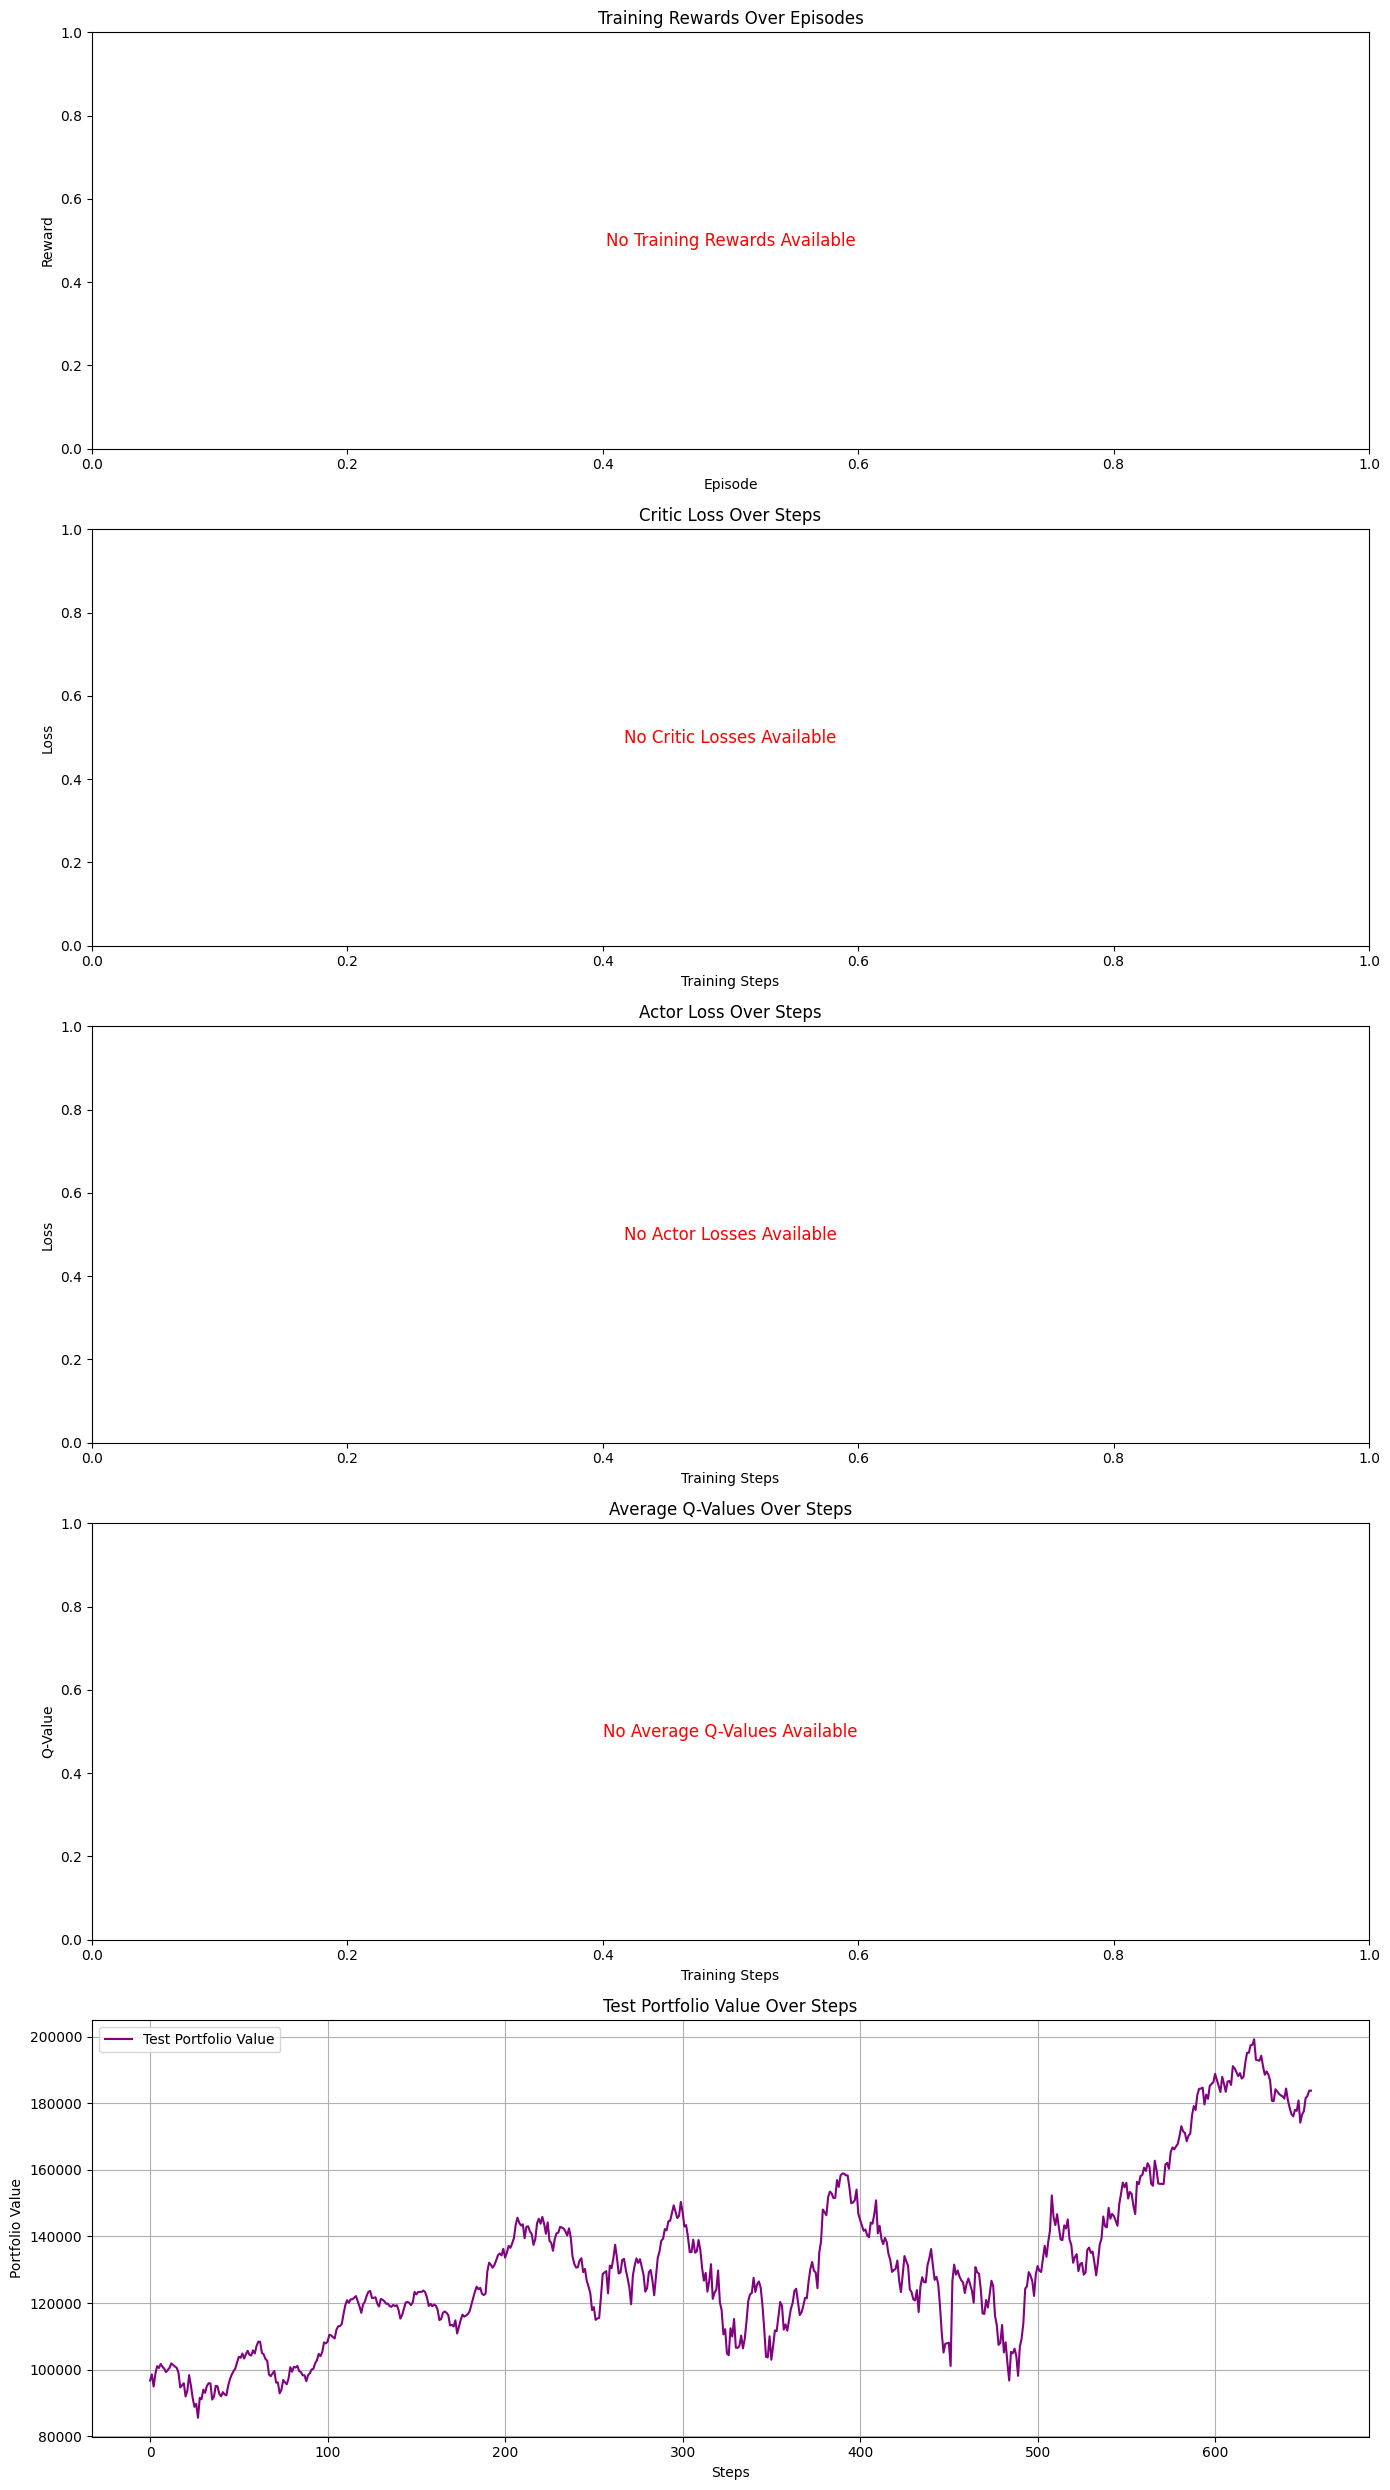


=== Test Summary Metrics ===
Cumulative Returns: 90.00%
Sharpe Ratio: 0.78
Sortino Ratio: 1.41
Maximum Drawdown: 39.12%


In [17]:
# test_ddpg_agent.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
# from your_module_name import PortfolioEnv, DDPGAgentAdaptive, test_agent, plot_metrics, calculate_returns  # Replace 'your_module_name' with the actual module name
import logging

# Configure logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    handler = logging.FileHandler("testing_ddpg.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

logger.propagate = False

def plot_metrics(train_metrics=None, test_metrics=None):
    """
    Plot training and testing metrics.
    
    Parameters:
    - train_metrics (dict): Metrics collected during training.
    - test_metrics (dict): Metrics collected during testing.
    
    Both dictionaries are optional. The function will plot available metrics.
    """
    fig, axs = plt.subplots(5, 1, figsize=(14, 25))
    
    # Plot Training Rewards if available
    if train_metrics and 'rewards' in train_metrics and len(train_metrics['rewards']) > 0:
        axs[0].plot(train_metrics['rewards'], label='Training Reward', color='blue')
        axs[0].set_title('Training Rewards Over Episodes')
        axs[0].set_xlabel('Episode')
        axs[0].set_ylabel('Reward')
        axs[0].legend()
        axs[0].grid(True)
    else:
        axs[0].text(0.5, 0.5, 'No Training Rewards Available', 
                   horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        axs[0].set_title('Training Rewards Over Episodes')
        axs[0].set_xlabel('Episode')
        axs[0].set_ylabel('Reward')
    
    # Plot Critic Losses if available
    if train_metrics and 'critic_losses' in train_metrics and len(train_metrics['critic_losses']) > 0:
        axs[1].plot(train_metrics['critic_losses'], label='Critic Loss', color='orange')
        axs[1].set_title('Critic Loss Over Steps')
        axs[1].set_xlabel('Training Steps')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].text(0.5, 0.5, 'No Critic Losses Available', 
                   horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        axs[1].set_title('Critic Loss Over Steps')
        axs[1].set_xlabel('Training Steps')
        axs[1].set_ylabel('Loss')
    
    # Plot Actor Losses if available
    if train_metrics and 'actor_losses' in train_metrics and len(train_metrics['actor_losses']) > 0:
        axs[2].plot(train_metrics['actor_losses'], label='Actor Loss', color='green')
        axs[2].set_title('Actor Loss Over Steps')
        axs[2].set_xlabel('Training Steps')
        axs[2].set_ylabel('Loss')
        axs[2].legend()
        axs[2].grid(True)
    else:
        axs[2].text(0.5, 0.5, 'No Actor Losses Available', 
                   horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        axs[2].set_title('Actor Loss Over Steps')
        axs[2].set_xlabel('Training Steps')
        axs[2].set_ylabel('Loss')
    
    # Plot Average Q-Values if available
    if train_metrics and 'avg_q_values' in train_metrics and len(train_metrics['avg_q_values']) > 0:
        axs[3].plot(train_metrics['avg_q_values'], label='Average Q-Value', color='red')
        axs[3].set_title('Average Q-Values Over Steps')
        axs[3].set_xlabel('Training Steps')
        axs[3].set_ylabel('Q-Value')
        axs[3].legend()
        axs[3].grid(True)
    else:
        axs[3].text(0.5, 0.5, 'No Average Q-Values Available', 
                   horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        axs[3].set_title('Average Q-Values Over Steps')
        axs[3].set_xlabel('Training Steps')
        axs[3].set_ylabel('Q-Value')
    
    # Plot Test Portfolio Values if available
    if test_metrics and 'portfolio_values' in test_metrics and len(test_metrics['portfolio_values']) > 0:
        axs[4].plot(test_metrics['portfolio_values'][0], label='Test Portfolio Value', color='purple')
        axs[4].set_title('Test Portfolio Value Over Steps')
        axs[4].set_xlabel('Steps')
        axs[4].set_ylabel('Portfolio Value')
        axs[4].legend()
        axs[4].grid(True)
    else:
        axs[4].text(0.5, 0.5, 'No Test Portfolio Values Available', 
                   horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        axs[4].set_title('Test Portfolio Value Over Steps')
        axs[4].set_xlabel('Steps')
        axs[4].set_ylabel('Portfolio Value')
    
    plt.tight_layout()
    plt.show()
    
    # Print Summary Metrics if available
    if test_metrics:
        print("\n=== Test Summary Metrics ===")
        if 'cumulative_returns' in test_metrics:
            print(f"Cumulative Returns: {test_metrics['cumulative_returns']:.2%}")
        if 'sharpe_ratio' in test_metrics:
            print(f"Sharpe Ratio: {test_metrics['sharpe_ratio']:.2f}")
        if 'sortino_ratio' in test_metrics:
            print(f"Sortino Ratio: {test_metrics['sortino_ratio']:.2f}")
        if 'max_drawdown' in test_metrics:
            print(f"Maximum Drawdown: {test_metrics['max_drawdown']:.2%}")
    else:
        print("\nNo Test Metrics Available to Display.")

def run_tests_with_saved_agent(agent_save_path, config):
    """
    Runs tests using a saved DDPG agent.
    
    Parameters:
    - agent_save_path (str): Path to the saved .pth file.
    - config (dict): Configuration dictionary for testing.
    
    Returns:
    - None
    """
    # Load data
    csv_file = config['csv_file']
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"The data file '{csv_file}' does not exist in the current directory.")
    df = pd.read_csv(csv_file, parse_dates=['Date'])
    print("Data loaded successfully.")
    
    # Add the 'data' key to config
    config['data'] = df
    
    # Calculate returns if not present
    if 'Return' not in df.columns:
        df = calculate_returns(df)
        config['data'] = df  # Update the 'data' key with returns
        print("Returns calculated and added to the DataFrame.")
    
    # Get symbols
    symbols = df['Symbol'].unique().tolist()
    config['symbols'] = symbols
    config['num_assets'] = len(symbols) + 1  # +1 for cash
    config['num_features'] = len(df.columns) - 3  # excluding Date, Symbol, Regime
    config['action_dim'] = config['num_assets']
    
    # Initialize scaler
    scaler = StandardScaler()
    feature_data = df.drop(['Date', 'Symbol', 'Regime'], axis=1).values
    scaler.fit(feature_data)
    config['scaler'] = scaler
    print("Feature scaler initialized and fitted.")
    
    # Define state_dim based on observation space
    config['state_dim'] = (config['num_assets'], config['window_length'], config['num_features'])
    
    # Initialize Environment for Testing
    config_test = config.copy()
    config_test['train'] = False
    config_test['train_start_date'] = None
    config_test['train_end_date'] = None
    config_test['test_start_date'] = '2021-01-01'
    config_test['test_end_date'] = '2023-08-31'
    
    # Extract test dates
    test_dates = sorted(config_test['data'][
        (config_test['data']['Date'] >= config_test['test_start_date']) & 
        (config_test['data']['Date'] <= config_test['test_end_date'])
    ]['Date'].unique())
    config_test['max_steps_test'] = len(test_dates) - config_test['window_length']
    
    env_test = PortfolioEnv(config_test)
    env_test.scaler = config['scaler']  # Use the same scaler
    env_test.risk_free_rate = config['risk_free_rate']  # Ensure same risk-free rate
    print("Environment initialized for testing.")
    
    # Initialize DDPG Agent
    agent = DDPGAgentAdaptive(config)
    print("DDPG agent initialized.")
    
    # Load the saved agent
    if not os.path.exists(agent_save_path):
        raise FileNotFoundError(f"The agent file '{agent_save_path}' does not exist.")
    agent.load(agent_save_path)
    # agent.eval()  # Set agent to evaluation mode
    agent.actor.eval()
    agent.critic.eval()
    print(f"Agent loaded from '{agent_save_path}'.")
    
    # Testing
    logger.info("Starting Testing with Saved Agent...")
    test_metrics = test_agent(env_test, agent, config_test)
    logger.info("Testing with Saved Agent Completed.")
    print("Testing with saved agent completed.")
    
    # Plot Metrics
    plot_metrics({}, test_metrics)  # No training metrics to plot

if __name__ == "__main__":
    # Configuration Dictionary
    config = {
        # General Parameters
        'initial_balance': 100000,
        'volatility_window': 30,
        'risk_free_rate': 0.02,
        'window_length': 15,
        
        # Reward Coefficients
        'reward_coefficients': {
            'return_weight': 1.0,
            'sharpe_weight': 0.005,
            'drawdown_penalty': 0.006,
        },
        
        # Data Parameters
        'csv_file': 'preprocessed_portfolio_data_with_Regimes.csv',
        'test_start_date': '2023-01-01',
        'test_end_date': '2023-12-31',

        'actor_lr': 1e-4,
        'critic_lr': 1e-3,
        'gamma': 0.99,
        'tau': 1e-3,
        'buffer_size': 200000,
        'batch_size': 64,
        'alpha': 0.6,
        'beta': 0.4,

        'device': device,
        'num_regimes': 2,
        'd_model': 256,
        'nhead': 8,
        'num_encoder_layers': 4,
        'dim_feedforward': 512,
        'dropout': 0.1,

    }

    # Path to the saved agent
    agent_save_path = 'ddpg_agent_adaptive.pth'

    # Run tests
    run_tests_with_saved_agent(agent_save_path, config)